In [ ]:
# Importing Library for Preprocessing 

import random 
import numpy as np
import matplotlib.pyplot as plt 
import torch 
import torchvision.transforms as transforms
import torch.utils.data as data 
import zipfile
import os 
import seaborn as sns
from tqdm import tqdm
import shutil
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split 

In [10]:
# Extract The data From The zip File 

def extract_data(zip_path,extract_to):
  
    os.makedirs(extract_to, exist_ok=True)

  
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted {len(zip_ref.namelist())} files to {extract_to}") 

# file paths
zip_file_path = r"D:\UNI (2)\Brain Tumor Project\archive.zip"
output_directory = r"D:\UNI (2)\Brain Tumor Project"


extract_data(zip_file_path, output_directory)  

Extracted 800 files to D:\UNI (2)\Brain Tumor Project


In [11]:

class_names = ["Healthy", "Tumor"]


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors (C, H, W)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values to [-1, 1]
])


dataset_path = r"D:\UNI (2)\Brain Tumor Project\Dataset"

# Custom Dataset Class with Missing File Handling
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.image_paths = []  # List to store image paths
        self.labels = []  # List to store labels

        # Define classes
        self.classes = {"healthy": 0, "tumor": 1}

        # Load images from both "healthy" and "tumor" directories
        for label, class_idx in self.classes.items():
            class_path = os.path.join(root_dir, label)  
            if not os.path.exists(class_path):  # Skip if the folder is missing
                print(f"⚠️ Warning: {class_path} does not exist, skipping...")
                continue

            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                if file.endswith(('.jpg', '.png', '.jpeg')) and os.path.exists(file_path):  
                    self.image_paths.append(file_path)
                    self.labels.append(class_idx)
                else:
                    print(f"❌ Skipped missing or invalid file: {file_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  
        label = self.labels[idx]  
        
        if self.transform:
            image = self.transform(image)  
        
        return image, label  
# Create dataset
dataset = BrainTumorDataset(root_dir=dataset_path, transform=transform)

# Use DataLoader to load images in batches
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Displaying one batch to verify
dataiter = iter(dataloader)
images, labels = next(dataiter)

print(f"Loaded batch shape: {images.shape}")
print(f"Labels: {labels}")

Loaded batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1])


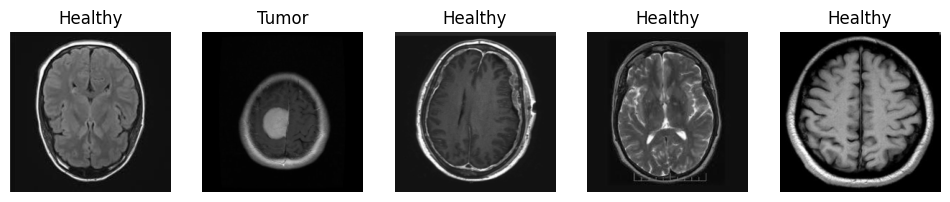

In [12]:
# Function to display images
def show_images(images, labels, class_names):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()  
        img = (img * 0.5) + 0.5  
        ax.imshow(img)
        ax.set_title(class_names[labels[i].item()])
        ax.axis("off")
    plt.show()


show_images(images[:5], labels[:5], class_names=["Healthy", "Tumor"])

In [13]:

def split_data(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert train_ratio + val_ratio + test_ratio == 1, "The sum of the ratios must be 1."

    # Output directory paths
    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")
    test_dir = os.path.join(output_dir, "test")

    # Create directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Read all subdirectories (healthy and tumor)
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)

        # Ensure it is a directory, not a file
        if not os.path.isdir(class_path):
            continue

        # Create corresponding directories inside train, val, and test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Collect all image files inside the subdirectory
        files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

        # Ensure there are images available
        if len(files) == 0:
            print(f"⚠️ No images found in {class_path}, skipping...")
            continue

        print(f"📂 Splitting {class_name}: {len(files)} images")

        # Split the data
        train_files, temp_files = train_test_split(files, test_size=(val_ratio + test_ratio), shuffle=True, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), shuffle=False, random_state=42)

        # Move images to their respective folders
        for file in train_files:
            shutil.move(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))
        for file in val_files:
            shutil.move(os.path.join(class_path, file), os.path.join(val_dir, class_name, file))
        for file in test_files:
            shutil.move(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

        print(f"✅ {class_name} - Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

    print("🎯 Data splitting completed successfully!")

# Run the function with your dataset paths
source_folder = r"D:\UNI (2)\Brain Tumor Project\Dataset"
output_folder = r"D:\UNI (2)\Brain Tumor Project\split_dataset"

split_data(source_folder, output_folder)

📂 Splitting healthy: 408 images
✅ healthy - Train: 285, Val: 61, Test: 62
📂 Splitting tumor: 392 images
✅ tumor - Train: 274, Val: 59, Test: 59
🎯 Data splitting completed successfully!


In [14]:
# augmentation transformations

augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of flipping
    transforms.RandomVerticalFlip(p=0.5),  # 50% chance of vertical flip
    transforms.RandomRotation(degrees=30),  # Rotate within ±30 degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Adjust brightness & contrast
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # Affine transform
])

# Paths
train_path = r"D:\UNI (2)\Brain Tumor Project\split_dataset\train"  # Original train data path

# Number of augmented images per original image
num_augmented = 5 

# Apply augmentation and save new images in the same class folder
for class_name in ["healthy", "tumor"]:
    class_path = os.path.join(train_path, class_name)  # Path to "healthy" or "tumor" folder

    if not os.path.exists(class_path):
        print(f"⚠️ Warning: {class_path} does not exist, skipping...")
        continue

    for file in tqdm(os.listdir(class_path), desc=f"Augmenting {class_name}"):
        input_file_path = os.path.join(class_path, file)

        # Ensure it's an image file
        if file.endswith(('.jpg', '.png', '.jpeg')):
            try:
                image = Image.open(input_file_path).convert("RGB")  # Open image in RGB mode

                # Generate multiple augmented versions
                for i in range(num_augmented):
                    augmented_image = augmentation_transforms(image)  # Apply augmentation
                    new_filename = f"{file.split('.')[0]}_aug{i}.jpg"  # Rename augmented file
                    augmented_image.save(os.path.join(class_path, new_filename))  # Save in the same class folder

            except Exception as e:
                print(f"❌ Error processing {input_file_path}: {e}")

print("✅ Augmented images saved successfully in their respective class folders!")


Augmenting tumor: 100%|██████████| 274/274 [00:18<00:00, 15.19it/s]

✅ Augmented images saved successfully in their respective class folders!


In [15]:
train_path = r"D:\UNI (2)\Brain Tumor Project\split_dataset\train"


for class_name in ["healthy", "tumor"]:
    class_path = os.path.join(train_path, class_name)
    if os.path.exists(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
        print(f"📊 {class_name.capitalize()} images: {num_images}")
    else:
        print(f"⚠️ {class_path} does not exist.")

📊 Healthy images: 1710
📊 Tumor images: 1644


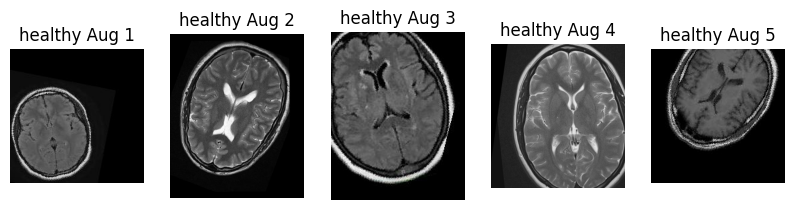

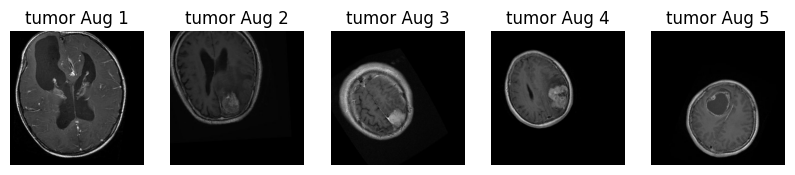

In [16]:

# Function to display random augmented images
def show_augmented_images(class_name, num_samples=5):
    class_path = os.path.join(train_path, class_name)
    if not os.path.exists(class_path):
        print(f"⚠️ {class_path} does not exist.")
        return

    # Get all augmented images
    augmented_images = [f for f in os.listdir(class_path) if "_aug" in f]
    
    if len(augmented_images) == 0:
        print(f"⚠️ No augmented images found in {class_name}.")
        return

    # Randomly select images to display
    sample_files = random.sample(augmented_images, min(num_samples, len(augmented_images)))
    
    plt.figure(figsize=(10, 5))
    for i, file in enumerate(sample_files):
        img_path = os.path.join(class_path, file)
        image = Image.open(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{class_name} Aug {i+1}")

    plt.show()

# Show augmented images for both classes
show_augmented_images("healthy")
show_augmented_images("tumor")

C:\Users\Dell\AppData\Local\Temp\ipykernel_19016\791052916.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels_list, palette=custom_colors)


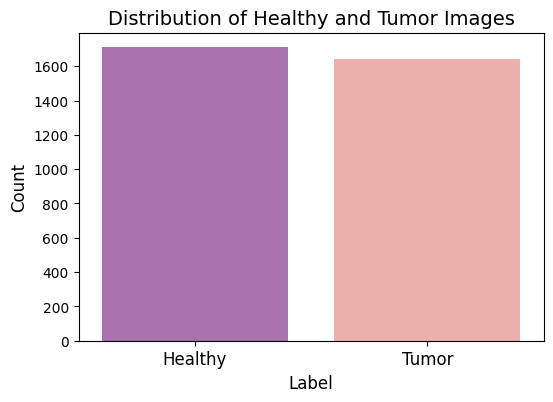

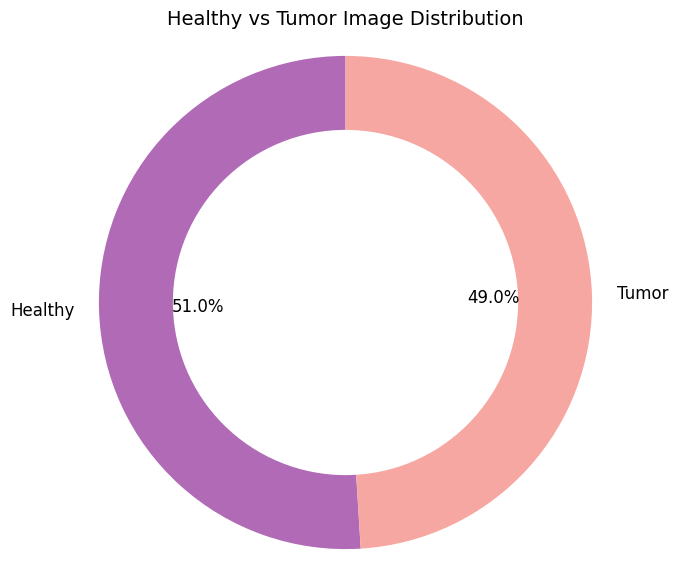

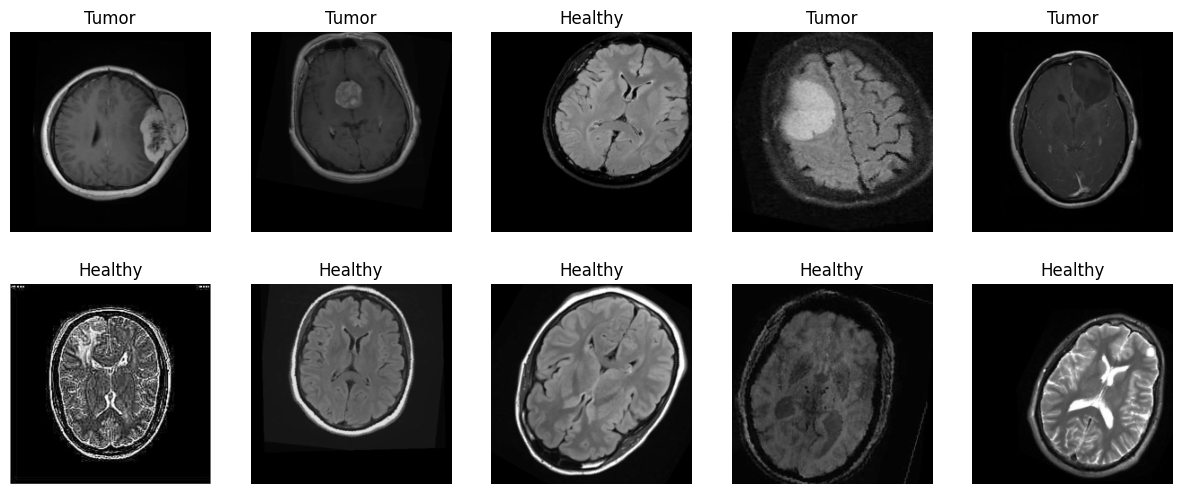

In [24]:
# Define class names and colors
class_names = ["Healthy", "Tumor"]
custom_colors = ['#B06AB6', '#F7A7A1']  # Light purple and pink

# Transformations: Resize, Convert to Tensor, Normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

dataset_path = r"D:\UNI (2)\Brain Tumor Project\split_dataset\train"

# Custom Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.image_paths = []  
        self.labels = []  
        self.classes = {"healthy": 0, "tumor": 1}

        # Load images from each class
        for label, class_idx in self.classes.items():
            class_path = os.path.join(root_dir, label)
            if not os.path.exists(class_path):
                print(f"⚠️ Warning: {class_path} does not exist, skipping...")
                continue

            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                if os.path.exists(file_path) and file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    self.image_paths.append(file_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  
        label = self.labels[idx]  
        
        if self.transform:
            image = self.transform(image)  
        
        return image, label  

# Create dataset
dataset = BrainTumorDataset(root_dir=dataset_path, transform=transform)

# Use DataLoader to load images in batches
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Extract labels for visualization
labels_list = [label for _, label in dataset]

# **1️⃣ Bar Plot: Distribution of Classes**
plt.figure(figsize=(6, 4))
sns.countplot(x=labels_list, palette=custom_colors)
plt.title('Distribution of Healthy and Tumor Images', fontsize=14)
plt.xticks([0, 1], class_names, fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# **2️⃣ Donut Chart: Percentage of Each Class**
healthy_count = labels_list.count(0)
tumor_count = labels_list.count(1)
sizes = [healthy_count, tumor_count]

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=class_names, colors=custom_colors, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 12})
centre_circle = plt.Circle((0, 0), 0.70, fc='white')  
fig = plt.gcf()
fig.gca().add_artist(centre_circle)  
plt.title('Healthy vs Tumor Image Distribution', fontsize=14)
plt.axis('equal')  
plt.show()

# **3️⃣ Sample Image Visualization**
def visualize_samples(dataloader, class_names, num_samples=10):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(2, num_samples // 2, figsize=(15, 6))
    for i in range(num_samples):
        image = images[i].permute(1, 2, 0).numpy()  
        image = (image * 0.5) + 0.5  

        row, col = divmod(i, num_samples // 2)
        axes[row, col].imshow(image)
        axes[row, col].set_title(class_names[labels[i].item()], fontsize=12)
        axes[row, col].axis("off")

    plt.show()

# Show 10 sample images
visualize_samples(dataloader, class_names)

Total Images: 3354
Min Width: 173, Max Width: 1024, Avg Width: 408
Min Height: 168, Max Height: 1075, Avg Height: 415


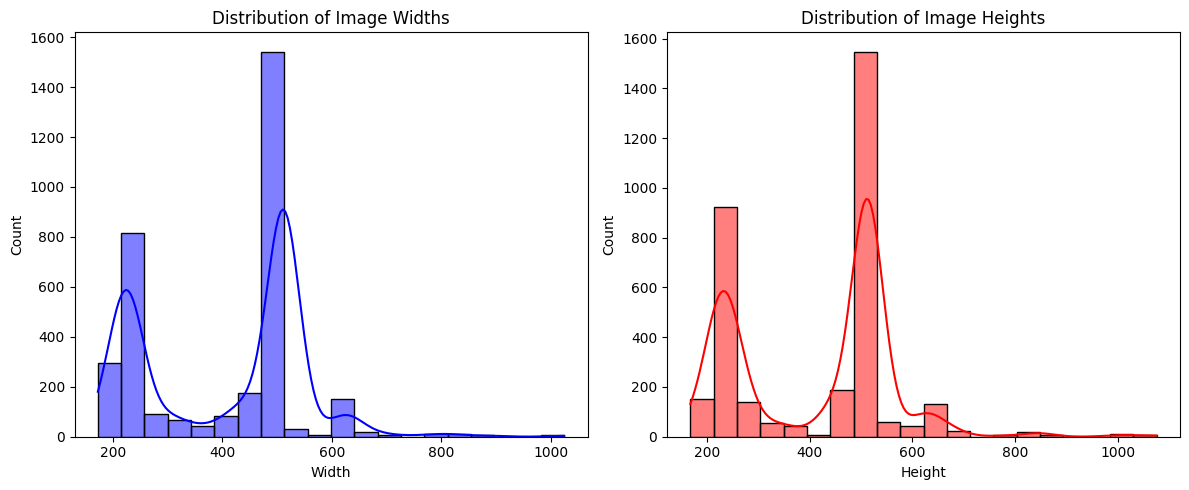

In [ ]:
# Image Size Distribution

# Dataset path
dataset_path = r"D:\UNI (2)\Brain Tumor Project\split_dataset\train"

# Lists to store image dimensions
image_widths = []
image_heights = []

# Iterate through each class folder ("healthy" and "tumor")
for class_name in ["healthy", "tumor"]:
    class_path = os.path.join(dataset_path, class_name)

    if not os.path.exists(class_path):
        print(f"⚠️ Warning: {class_path} does not exist, skipping...")
        continue

    for file in os.listdir(class_path):
        file_path = os.path.join(class_path, file)

        # Ensure it's an image file
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            try:
                image = Image.open(file_path)
                width, height = image.size  # Get image dimensions
                image_widths.append(width)
                image_heights.append(height)
            except Exception as e:
                print(f"❌ Error processing {file_path}: {e}")

# Print min, max, and average dimensions
print(f"Total Images: {len(image_widths)}")
print(f"Min Width: {min(image_widths)}, Max Width: {max(image_widths)}, Avg Width: {sum(image_widths)//len(image_widths)}")
print(f"Min Height: {min(image_heights)}, Max Height: {max(image_heights)}, Avg Height: {sum(image_heights)//len(image_heights)}")

# Plot distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(image_widths, bins=20, kde=True, color='blue')
plt.xlabel("Width")
plt.ylabel("Count")
plt.title("Distribution of Image Widths")

plt.subplot(1, 2, 2)
sns.histplot(image_heights, bins=20, kde=True, color='red')
plt.xlabel("Height")
plt.ylabel("Count")
plt.title("Distribution of Image Heights")

plt.tight_layout()
plt.show()